In [1]:
import os
os.chdir("/Users/ieo5776/Desktop/signal_processing_course/")
import numpy as np
import matplotlib.pyplot as plt
import scipy.fftpack
import scipy.signal
import scipy.io
from scipy.interpolate import griddata
from tools import denoise
import copy

# Fix the signal

This challenge presents outliers, irregularly sampled data and missing data points. Here's the three things i need to focus on:
1) NaN's in the data, this will trip up filters/FFT and so on.
2) Two noise bursts, interpolate across?
3) Resample the TS to regularly spaced.

# Solution
After a couple of tries i though to take the average (median works too) of surroundings points for NaN's, then use spectral interpolation and finally upsample with either linear or spline interpolation to have a regularly sampled signal.

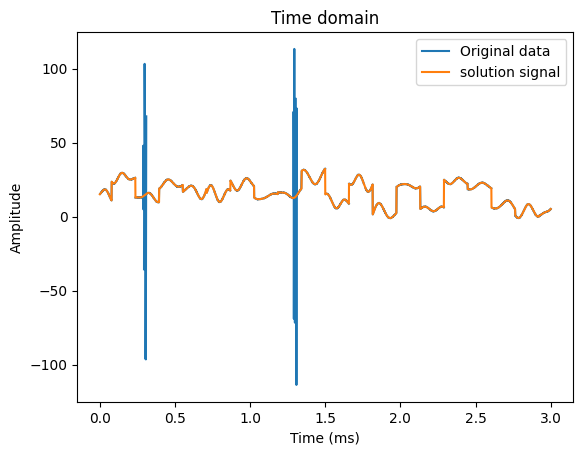

In [13]:
mat = scipy.io.loadmat("SignalProcessing/resample/resample_codeChallenge.mat")
mat
original_signal = mat['signal'][:,0]
original_time = mat['time'][0]
# Fixed signal
fixed_signal = mat['origS'][:,0]
fixed_time = mat['origT'][0]


plt.plot(original_time, original_signal, label="Original data")
plt.plot(fixed_time, fixed_signal, label="solution signal")
plt.legend()
plt.xlabel("Time (ms)")
plt.ylabel("Amplitude")
plt.title("Time domain")
plt.show()


In [3]:
# Remove NaN's with the median of the adjecent points
where_nan = np.where(np.isnan(original_signal))

# for loop to update the array
new_signal = copy.deepcopy(original_signal)

for _, x in enumerate(where_nan[0]):
	new_signal[x] = np.nanmedian(np.array([new_signal[x-1:x], new_signal[x:x+1]]))
	

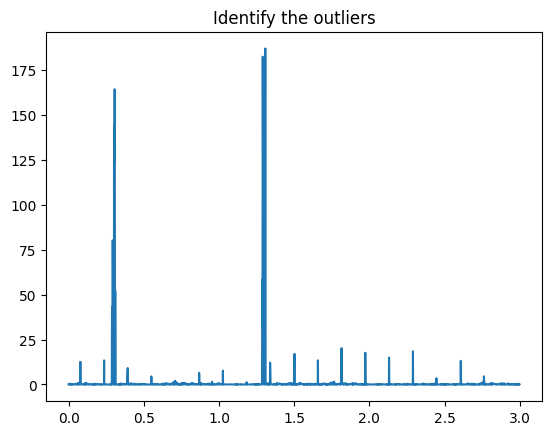

In [4]:
plt.plot(original_time[0:-1], np.abs(np.diff(new_signal)))
plt.title('Identify the outliers')

spikes = np.where(np.abs(np.diff(new_signal)) > 25)
end_peak = np.argmax(np.diff(spikes[0]))

In [5]:
# remove specific windows
boundaryPnts = [[spikes[0][0], spikes[0][end_peak]+1], [spikes[0][end_peak+1], spikes[0][-1]+1]]
boundaryPnts

new_signal[range(boundaryPnts[0][0],boundaryPnts[0][1])] = np.nan
new_signal[range(boundaryPnts[1][0],boundaryPnts[1][1])] = np.nan

for i in range(0, len(boundaryPnts)):
# FFTs of pre- and post-window data
	fftPre = scipy.fftpack.fft(new_signal[ range(boundaryPnts[i][0]-int(np.diff(boundaryPnts[i])),boundaryPnts[i][0])] )
	fftPst = scipy.fftpack.fft(new_signal[ range(boundaryPnts[i][1]+1,boundaryPnts[i][1]+int(np.diff(boundaryPnts[i])+1))] )

	# interpolated signal
	mixeddata = scipy.signal.detrend( np.real(scipy.fftpack.ifft( ( fftPre+fftPst )/2 )))
	linedata  = np.linspace(0,1,int(np.diff(boundaryPnts[i]))) * (new_signal[boundaryPnts[i][1]+1]-new_signal[boundaryPnts[i][0]-1]) + new_signal[boundaryPnts[i][0]-1]
	linterp = mixeddata + linedata

	new_signal[ range(boundaryPnts[i][0],boundaryPnts[i][1]) ] = linterp

In [6]:
# make it regularly sampled
resampled_data = griddata(original_time, new_signal, fixed_time, method='linear')

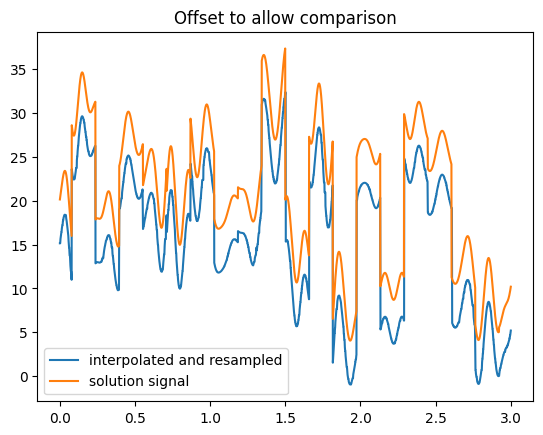

In [12]:
plt.plot(fixed_time, resampled_data, label="interpolated and resampled")
plt.plot(fixed_time, fixed_signal+5, label="solution signal")
plt.legend()
plt.title('Offset to allow comparison')
plt.show()